Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

First 5 rows of the dataset:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1  

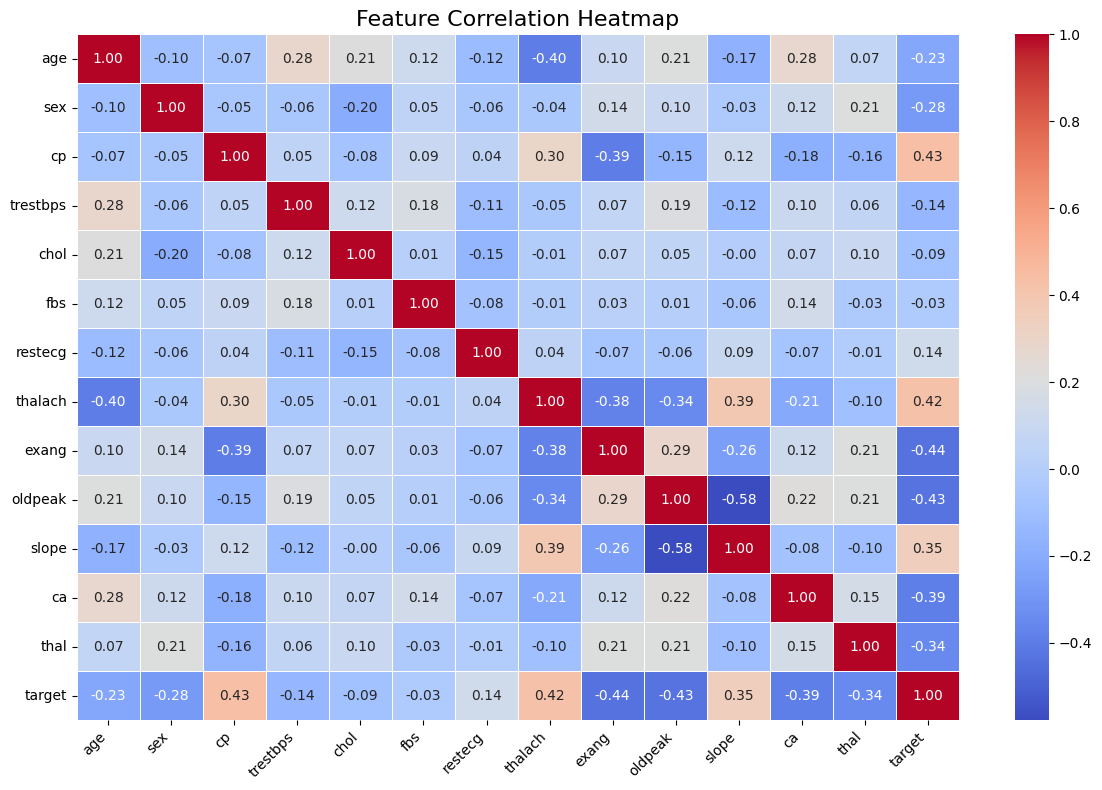


--- Model Evaluation with 5-Fold Cross-Validation ---

Model: Logistic Regression
Cross-Validation Accuracy (Mean): 0.8447
Cross-Validation Accuracy (Std Dev): 0.0406
Test Set Accuracy: 0.8688524590163934
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85        28
           1       0.86      0.91      0.88        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

Confusion Matrix:
 [[23  5]
 [ 3 30]]

Model: K-Nearest Neighbors
Cross-Validation Accuracy (Mean): 0.8415
Cross-Validation Accuracy (Std Dev): 0.0477
Test Set Accuracy: 0.7704918032786885
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.68      0.73        28
           1       0.76      0.85      0.80        33

    accuracy                           0.77        61
   macro avg

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load dataset
#url = "https://raw.githubusercontent.com/ybifoundation/Dataset/main/Heart%20Disease.csv"
df = pd.read_csv("/content/heart.csv")

# Display basic information about the dataset
print("Dataset Info:")
df.info()
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDescriptive Statistics:")
print(df.describe())

# Visualize correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Identify categorical and numerical features
# Based on the dataset description and common understanding of heart disease features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Create a preprocessor using ColumnTransformer for different transformations on different columns
# OneHotEncoder for categorical features and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Using stratify=y ensures that the proportion of target classes is the same in both train and test sets

# Define models with pipelines including the preprocessor
# This ensures that preprocessing (scaling and encoding) is applied consistently
logistic_regression_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                               ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])

decision_tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('classifier', DecisionTreeClassifier(random_state=42))])

# --- Model Training and Evaluation with Cross-Validation ---

models = {
    'Logistic Regression': logistic_regression_pipeline,
    'K-Nearest Neighbors': knn_pipeline,
    'Decision Tree': decision_tree_pipeline
}

print("\n--- Model Evaluation with 5-Fold Cross-Validation ---")
for name, pipeline in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy') # Use full dataset for CV
    print(f"\nModel: {name}")
    print(f"Cross-Validation Accuracy (Mean): {cv_scores.mean():.4f}")
    print(f"Cross-Validation Accuracy (Std Dev): {cv_scores.std():.4f}")

    # Train the model on the training set and evaluate on the test set for a final report
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- Hyperparameter Tuning for KNN using GridSearchCV ---
print("\n--- Hyperparameter Tuning for K-Nearest Neighbors ---")

# Define the parameter grid for KNN
# Note: 'classifier__' prefix is used because 'classifier' is the name of the step in the pipeline
param_grid_knn = {
    'classifier__n_neighbors': range(1, 21), # Test k from 1 to 20
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)

print(f"\nBest parameters for KNN: {grid_search_knn.best_params_}")
print(f"Best cross-validation accuracy for KNN: {grid_search_knn.best_score_:.4f}")

# Evaluate the best KNN model on the test set
best_knn_pred = grid_search_knn.predict(X_test)
print("\n--- Evaluation of Tuned K-Nearest Neighbors Model ---")
print("Test Set Accuracy (Tuned KNN):", accuracy_score(y_test, best_knn_pred))
print("Classification Report (Tuned KNN):\n", classification_report(y_test, best_knn_pred))
print("Confusion Matrix (Tuned KNN):\n", confusion_matrix(y_test, best_knn_pred))